In [1]:
# Import library yg diperlukan
from datasets import load_dataset

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import warnings
import os
import nltk

from IPython.display import Audio
from transformers import pipeline
from datasets import load_dataset
from time import time


warnings.filterwarnings('ignore')
nltk.download('punkt')


c:\Users\lelgr\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lelgr\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# load dataset dan pilih inggris dengan dialek Australia karena memliki jumlah sampel terbanyak dibanding bahasa Inggris dengan dialek lainnya
minds_14 = load_dataset("PolyAI/minds14", "en-AU", trust_remote_code=True)

In [3]:
df = pd.DataFrame(minds_14)

In [4]:
df = pd.DataFrame(minds_14["train"])

In [5]:
df

,path,audio,transcription,english_transcription,intent_class,lang_id
0,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2
1,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,13,2
2,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,pay a bill,pay a bill,13,2
3,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,my credit card payment is due,my credit card payment is due,13,2
4,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2
...,...,...,...,...,...,...
649,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I deposit money,I deposit money,7,2
650,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how do I transfer money to my account,how do I transfer money to my account,7,2
651,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how can I transfer money into the account,how can I transfer money into the account,7,2
652,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi hello I'm trying to find out how to transfe...,hi hello I'm trying to find out how to transfe...,7,2


## Histogram Durasi Distribusi Audio

In [6]:
# buat fungsi untuk menhitung durasi dari audio
def calculate_duration(audio_path):
    audio, sr = librosa.load(audio_path)
    duration = len(audio) / sr
    return duration

# menerapkan fungsi tersebut ke setiap audio
df['duration'] = df['path'].apply(calculate_duration)

In [7]:
df['duration'].describe()

count    654.000000
mean       8.403427
std        5.638557
min        1.950522
25%        4.617029
50%        6.630000
75%       10.325397
max       57.399773
Name: duration, dtype: float64

<Axes: ylabel='Frequency'>

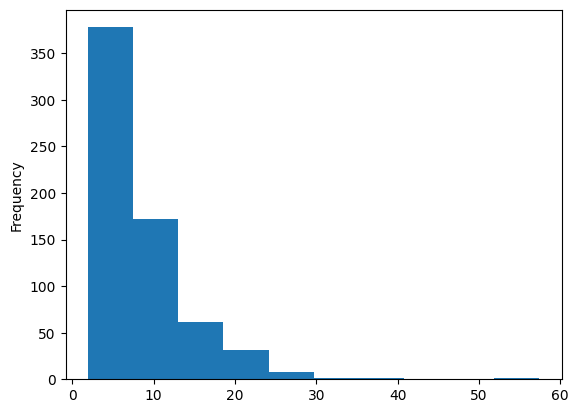

In [8]:
df['duration'].plot(kind = 'hist')

75% dari dataset memiliki durasi yang pendek, di sekitar 10 detik. Akan tetapi, beberapa dataset mempunyai durasi yang cukup panjang, mencapai sekitar 1 menit. Oleh karena itu, distribusi menjadi long-tail alias right-skewed.

## Analisa data berdasarkan inten

In [9]:
intent_class_interpret = list()
for idx in df.index:
  intent_class = minds_14["train"][idx]["intent_class"]
  interpret = minds_14['train'].features['intent_class'].names[intent_class]
  intent_class_interpret.append(interpret)

df['intent_class_interpret'] = intent_class_interpret

### a. Bar chart untuk distribusi jumlah data tiap data berdasarkan intensi

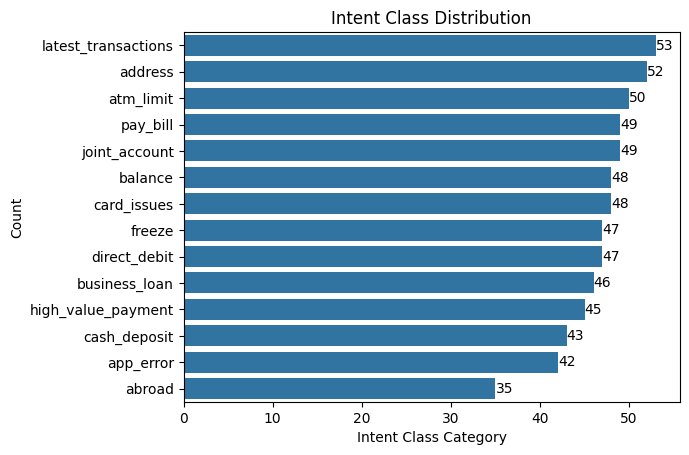

In [10]:
sorted_counts = df['intent_class_interpret'].value_counts().sort_values(ascending=False)
sorted_categories = sorted_counts.index

ax = sns.countplot(y='intent_class_interpret', data=df, order=sorted_categories)

for p in ax.patches:
    count = int(p.get_width())  # Get the count for each bar
    ax.annotate(f'{count}',  # The text to display (count)
                (count, p.get_y() + p.get_height() / 2),  # Position the label
                ha='left',  # Horizontal alignment
                va='center',  # Vertical alignment
                color='black')  # Text color

plt.title('Intent Class Distribution')
plt.xlabel('Intent Class Category')
plt.ylabel('Count')

plt.show()

Permasalahan customer yang paling sering terjadi adalah mengenai transaksi terakhir, disusul oleh alamat lalu limit ATM. Yang paling jarang terjadi adalah masalah transaksi luar negeri.

### b. Boxplot durasi dibagi berdasarkan intensi

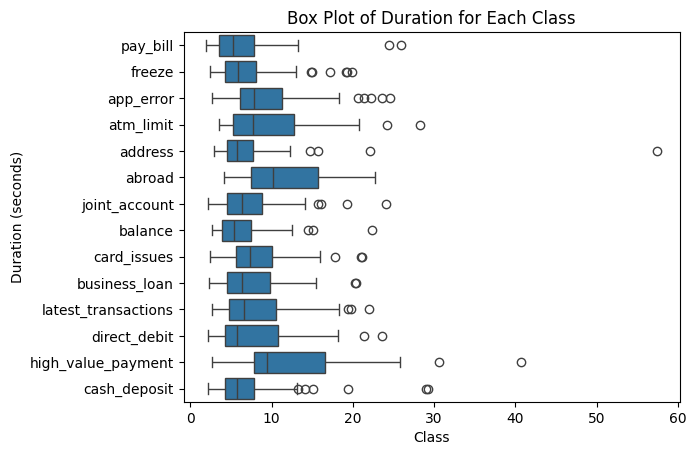

In [11]:
sns.boxplot(y='intent_class_interpret', x='duration', data=df)

plt.title('Box Plot of Duration for Each Class')
plt.xlabel('Class')
plt.ylabel('Duration (seconds)')

plt.show()

Durasi komunikasi cenderung panjang untuk permasalahan high-value payment dan transaksi luar negeri, ini kemungkinan menandakan permasalahan terkait topik tersebut memakan waktu yang lebih panjang, dan proses yang seksama dikarenakan tingkat risiko yang lebih tinggi. Permasalahan seperti, pembayaran bill, cash deposit, dan aplikasi yg error cenderung memilki durasi yang lebih pendek, mungkin karena resolusi tidak terlalu pelik.

## Analisa Audio

In [12]:
df

,path,audio,transcription,english_transcription,intent_class,lang_id,duration,intent_class_interpret
0,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2,7.801905,pay_bill
1,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,13,2,7.936009,pay_bill
2,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,pay a bill,pay a bill,13,2,4.179637,pay_bill
3,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,my credit card payment is due,my credit card payment is due,13,2,2.816009,pay_bill
4,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2,4.266667,pay_bill
...,...,...,...,...,...,...,...,...
649,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I deposit money,I deposit money,7,2,4.829751,cash_deposit
650,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how do I transfer money to my account,how do I transfer money to my account,7,2,3.584036,cash_deposit
651,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how can I transfer money into the account,how can I transfer money into the account,7,2,3.250794,cash_deposit
652,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi hello I'm trying to find out how to transfe...,hi hello I'm trying to find out how to transfe...,7,2,7.680000,cash_deposit


In [13]:
df.iloc[0]

path                      C:\Users\lelgr\.cache\huggingface\datasets\dow...
audio                     {'path': 'C:\Users\lelgr\.cache\huggingface\da...
transcription             I would like to pay my electricity bill using ...
english_transcription     I would like to pay my electricity bill using ...
intent_class                                                             13
lang_id                                                                   2
duration                                                           7.801905
intent_class_interpret                                             pay_bill
Name: 0, dtype: object

In [14]:
sample_audio = df.iloc[0]['audio']['array']
sample_sr = df.iloc[0]['audio']['sampling_rate']

sample_audio, sample_sr

(array([ 0.        ,  0.00024414, -0.00024414, ..., -0.00024414,
         0.00024414,  0.0012207 ]),
 8000)

Memutar audio

In [15]:
audio_player = Audio(data=sample_audio, rate=sample_sr)
audio_player

### a. Waveplot

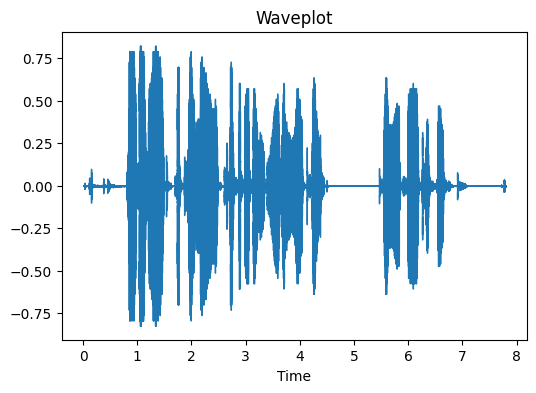

In [16]:
plt.figure(figsize=(6, 4))
librosa.display.waveshow(sample_audio, sr=sample_sr)
plt.title("Waveplot")
plt.show()
     

### b. Spectogram

Spektogram ini menunjukkan perubahan frekuensi dan amplitudo sinyal seiring waktu. Pada sumbu horizontal (waktu), kita bisa melihat bagaimana sinyal berubah dari detik ke detik. Sumbu vertikal menunjukkan frekuensi, dengan area yang lebih terang atau berwarna menandakan intensitas atau kekuatan sinyal pada frekuensi tertentu.

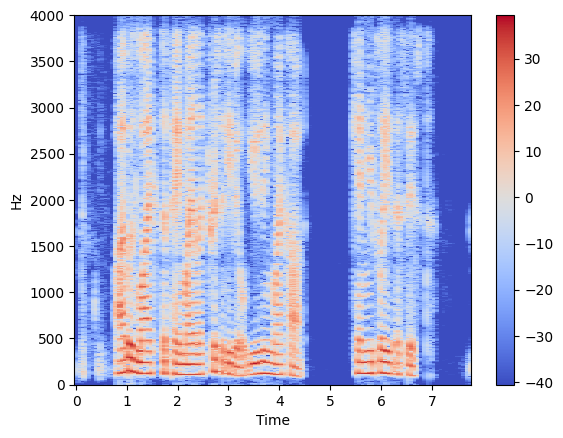

In [17]:
X = librosa.stft(sample_audio)
Xdb = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(Xdb, sr=sample_sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

Dari grafik, terlihat ada pola yang berulang atau fluktuasi tertentu, terutama di bagian tengah, yang mungkin mengindikasikan adanya pola periodik atau sinyal tertentu yang dominan. Di sisi lain, ada juga area yang lebih gelap atau rendah intensitasnya, menunjukkan frekuensi yang kurang dominan atau bahkan noise.

### c. MFCC

(20, 122)


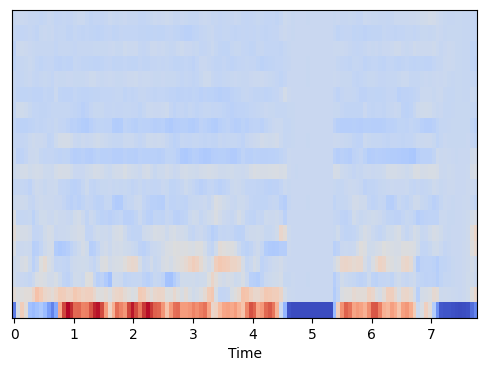

In [18]:

fs = 10
mfccs = librosa.feature.mfcc(y=sample_audio, sr=fs)
print(mfccs.shape)

plt.figure(figsize=(6, 4))
librosa.display.specshow(mfccs, sr=sample_sr, x_axis='time')
plt.show()
     

## Analisa transkripsi

In [19]:
df

,path,audio,transcription,english_transcription,intent_class,lang_id,duration,intent_class_interpret
0,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I would like to pay my electricity bill using ...,I would like to pay my electricity bill using ...,13,2,7.801905,pay_bill
1,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hello I like to pay for Bill I would actually ...,hello I like to pay for Bill I would actually ...,13,2,7.936009,pay_bill
2,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,pay a bill,pay a bill,13,2,4.179637,pay_bill
3,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,my credit card payment is due,my credit card payment is due,13,2,2.816009,pay_bill
4,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi I would like to make a new payment for a bill,hi I would like to make a new payment for a bill,13,2,4.266667,pay_bill
...,...,...,...,...,...,...,...,...
649,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,I deposit money,I deposit money,7,2,4.829751,cash_deposit
650,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how do I transfer money to my account,how do I transfer money to my account,7,2,3.584036,cash_deposit
651,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,how can I transfer money into the account,how can I transfer money into the account,7,2,3.250794,cash_deposit
652,C:\Users\lelgr\.cache\huggingface\datasets\dow...,{'path': 'C:\Users\lelgr\.cache\huggingface\da...,hi hello I'm trying to find out how to transfe...,hi hello I'm trying to find out how to transfe...,7,2,7.680000,cash_deposit


In [20]:
from collections import Counter
from wordcloud import WordCloud

# 1. Panjang Kalimat (Jumlah Kata)
df['word_count'] = df['transcription'].apply(lambda x: len(x.split()))

In [21]:
df['word_count'].describe()

count    654.000000
mean      16.581040
std       12.034102
min        2.000000
25%        8.000000
50%       13.000000
75%       21.000000
max       77.000000
Name: word_count, dtype: float64

Kebanyakan transkripsi cukup pendek (krg dari 20 kata), meski beberapa ada yang cukup panjang (hampir 80 kata)

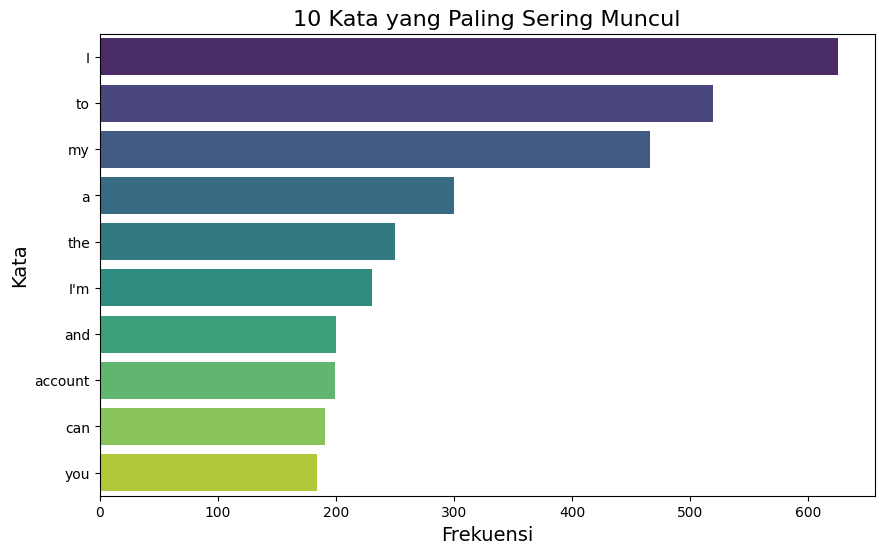

In [22]:
# Gabungkan semua kata dari kolom 'transcription'
all_words = ' '.join(df['transcription']).split()

# Hitung frekuensi kata
word_freq = Counter(all_words)

# Ambil 10 kata paling sering muncul
most_common_words = word_freq.most_common(10)

# Pisahkan kata dan frekuensi untuk plotting
words, frequencies = zip(*most_common_words)

# Buat bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=list(frequencies), y=list(words), palette='viridis')
plt.title('10 Kata yang Paling Sering Muncul', fontsize=16)
plt.xlabel('Frekuensi', fontsize=14)
plt.ylabel('Kata', fontsize=14)
plt.show()

In [23]:

# 3. Kata yang Sering Muncul per 'intent_class_interpret'
intent_classes = df['intent_class_interpret'].unique()
for intent in intent_classes:
    intent_words = ' '.join(df[df['intent_class_interpret'] == intent]['transcription']).split()
    intent_word_freq = Counter(intent_words)
    print(f"Kata yang sering muncul untuk intent class '{intent}':", intent_word_freq.most_common(5))

Kata yang sering muncul untuk intent class 'pay_bill': [('to', 49), ('I', 42), ('bill', 35), ('a', 34), ('pay', 27)]
Kata yang sering muncul untuk intent class 'freeze': [('my', 57), ('card', 42), ('I', 31), ('to', 28), ('freeze', 27)]
Kata yang sering muncul untuk intent class 'app_error': [('the', 53), ('app', 40), ('I', 32), ('my', 26), ('not', 23)]
Kata yang sering muncul untuk intent class 'atm_limit': [('I', 66), ('the', 64), ('can', 42), ('ATM', 36), ('to', 33)]
Kata yang sering muncul untuk intent class 'address': [('my', 61), ('address', 55), ('I', 50), ('to', 50), ('change', 44)]
Kata yang sering muncul untuk intent class 'abroad': [('I', 60), ('to', 52), ('card', 29), ("I'm", 27), ('my', 24)]
Kata yang sering muncul untuk intent class 'joint_account': [('account', 54), ('I', 52), ('joint', 44), ('to', 42), ('a', 41)]
Kata yang sering muncul untuk intent class 'balance': [('account', 54), ('balance', 49), ('my', 47), ('I', 30), ('to', 21)]
Kata yang sering muncul untuk intent

In [24]:
# 4. Panjang Rata-rata Transkripsi per 'intent_class_interpret'
intent_length = df.groupby('intent_class_interpret')['word_count'].mean().reset_index()
print("Panjang rata-rata transkripsi per intent class:")
print(intent_length)

Panjang rata-rata transkripsi per intent class:
   intent_class_interpret  word_count
0                  abroad   19.085714
1                 address   11.711538
2               app_error   19.095238
3               atm_limit   19.980000
4                 balance   11.729167
5           business_loan   14.391304
6             card_issues   19.416667
7            cash_deposit   15.790698
8            direct_debit   17.978723
9                  freeze   13.978723
10     high_value_payment   25.044444
11          joint_account   17.040816
12    latest_transactions   15.509434
13               pay_bill   13.142857


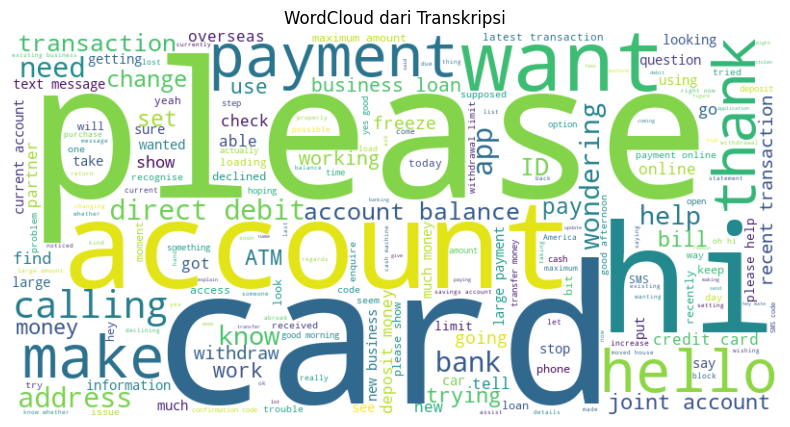

In [25]:

# 5. Visualisasi WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['transcription']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud dari Transkripsi')
plt.show()


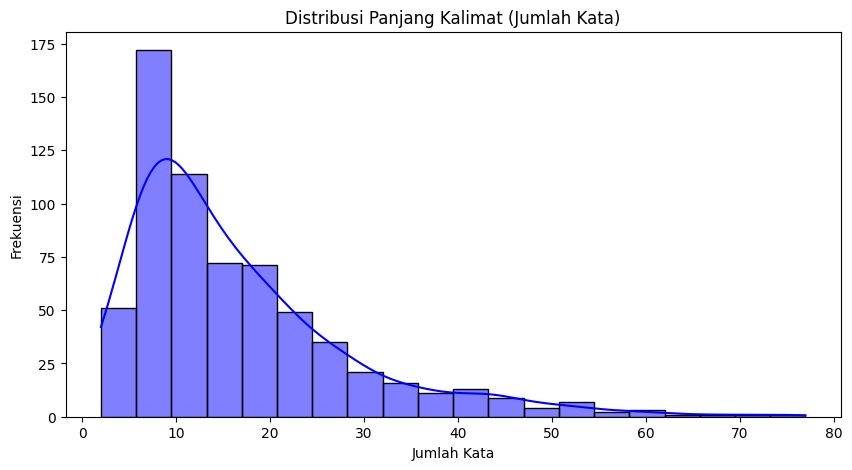

In [26]:

# 6. Visualisasi Distribusi Panjang Kalimat
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=20, kde=True, color='blue')
plt.title('Distribusi Panjang Kalimat (Jumlah Kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()


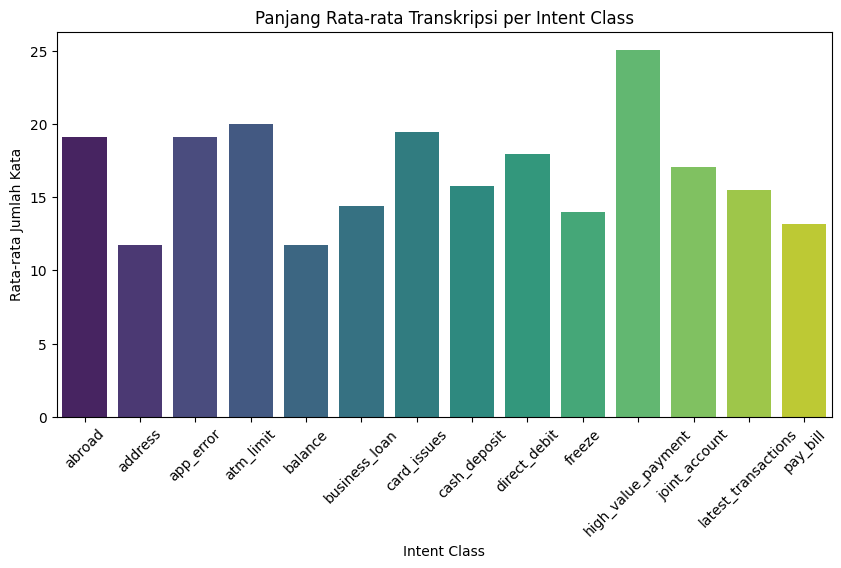

In [27]:

# 7. Visualisasi Panjang Rata-rata per Intent Class
plt.figure(figsize=(10, 5))
sns.barplot(x='intent_class_interpret', y='word_count', data=intent_length, palette='viridis')
plt.title('Panjang Rata-rata Transkripsi per Intent Class')
plt.xlabel('Intent Class')
plt.ylabel('Rata-rata Jumlah Kata')
plt.xticks(rotation=45)
plt.show()

## Modelling

In [29]:
pip install torch transformers datasets evaluate jiwer


     -------------------------------------- 84.0/84.0 kB 152.1 kB/s eta 0:00:00
     -------------------------------------- 98.2/98.2 kB 374.2 kB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 1.9 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

In [31]:
from transformers import WhisperForConditionalGeneration, Wav2Vec2ForCTC, AutoProcessor
import torch

# Load Whisper Large V3
whisper_processor = AutoProcessor.from_pretrained("openai/whisper-large-v3")
whisper_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-large-v3")

# Load Wav2Vec2 Base
wav2vec2_processor = AutoProcessor.from_pretrained("facebook/wav2vec2-base")
wav2vec2_model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
import jiwer

def calculate_wer_and_accuracy(predictions, references):
    # Calculate WER
    wer = jiwer.wer(references, predictions)
    
    # Calculate Accuracy (1 - WER)
    accuracy = 1 - wer
    
    return wer, accuracy

In [41]:
pip install torchaudio


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 2.5/2.5 MB 1.6 MB/s eta 0:00:00


In [43]:
import torchaudio

# Function to resample audio to 16,000 Hz
def resample_audio(audio_array, original_sample_rate, target_sample_rate=16000):
    # Convert the audio array to a PyTorch tensor
    waveform = torch.tensor(audio_array, dtype=torch.float32)
    
    # Resample if the sample rate is not 16,000 Hz
    if original_sample_rate != target_sample_rate:
        resampler = torchaudio.transforms.Resample(orig_freq=original_sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
    
    return waveform.numpy(), target_sample_rate

# Function to preprocess and predict using Whisper
def predict_with_whisper(audio_array, sampling_rate):
    # Resample the audio to 16,000 Hz
    waveform, sample_rate = resample_audio(audio_array, sampling_rate)
    
    # Process the audio with Whisper
    inputs = whisper_processor(waveform, sampling_rate=sample_rate, return_tensors="pt")
    predicted_ids = whisper_model.generate(inputs.input_features)
    transcription = whisper_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

# Function to preprocess and predict using Wav2Vec2
def predict_with_wav2vec2(audio_array, sampling_rate):
    # Resample the audio to 16,000 Hz (Wav2Vec2 also expects 16,000 Hz)
    waveform, sample_rate = resample_audio(audio_array, sampling_rate)
    
    # Process the audio with Wav2Vec2
    inputs = wav2vec2_processor(waveform, sampling_rate=sample_rate, return_tensors="pt")
    with torch.no_grad():
        logits = wav2vec2_model(inputs.input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = wav2vec2_processor.batch_decode(predicted_ids)[0]
    return transcription

# Evaluate Whisper
whisper_predictions = [predict_with_whisper(row['audio']['array'], row['audio']['sampling_rate']) for _, row in test_df.iterrows()]
whisper_wer, whisper_accuracy = calculate_wer_and_accuracy(whisper_predictions, test_df['transcription'].tolist())

# Evaluate Wav2Vec2
wav2vec2_predictions = [predict_with_wav2vec2(row['audio']['array'], row['audio']['sampling_rate']) for _, row in test_df.iterrows()]
wav2vec2_wer, wav2vec2_accuracy = calculate_wer_and_accuracy(wav2vec2_predictions, test_df['transcription'].tolist())

print(f"Whisper Large V3 - WER: {whisper_wer}, Accuracy: {whisper_accuracy}")
print(f"Wav2Vec2 Base - WER: {wav2vec2_wer}, Accuracy: {wav2vec2_accuracy}")

Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Whisper Large V3 - WER: 0.3374358974358974, Accuracy: 0.6625641025641026
Wav2Vec2 Base - WER: 1.113846153846154, Accuracy: -0.11384615384615393


In [44]:
import jiwer

def calculate_wer_and_accuracy(predictions, references):
    """
    Calculate Word Error Rate (WER) and Accuracy.
    WER = (Substitutions + Insertions + Deletions) / Total Words in Reference
    Accuracy = 1 - WER
    """
    # Compute WER using jiwer
    wer = jiwer.wer(references, predictions)
    
    # Ensure WER is within valid range [0, 1]
    wer = min(wer, 1.0)  # Cap WER at 1.0 (100%)
    
    # Calculate accuracy
    accuracy = 1 - wer
    
    return wer, accuracy

# Evaluate Whisper
whisper_predictions = [predict_with_whisper(row['audio']['array'], row['audio']['sampling_rate']) for _, row in test_df.iterrows()]
whisper_wer, whisper_accuracy = calculate_wer_and_accuracy(whisper_predictions, test_df['transcription'].tolist())

# Evaluate Wav2Vec2
wav2vec2_predictions = [predict_with_wav2vec2(row['audio']['array'], row['audio']['sampling_rate']) for _, row in test_df.iterrows()]
wav2vec2_wer, wav2vec2_accuracy = calculate_wer_and_accuracy(wav2vec2_predictions, test_df['transcription'].tolist())

print(f"Whisper Large V3 - WER: {whisper_wer}, Accuracy: {whisper_accuracy}")
print(f"Wav2Vec2 Base - WER: {wav2vec2_wer}, Accuracy: {wav2vec2_accuracy}")

Whisper Large V3 - WER: 0.3374358974358974, Accuracy: 0.6625641025641026
Wav2Vec2 Base - WER: 1.0, Accuracy: 0.0
